In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tpclean.tpclean as tp
import seaborn as sns

In [2]:
!ls

LICENSE         README.md       database.sqlite responses.csv
Project_3.ipynb columns.csv     index.ipynb


In [3]:
tp.sql_connect("database.sqlite")

Connection to database.sqlite successfull. with curser <sqlite3.Cursor object at 0x1a25844180>


In [4]:
db_tbls_df = tp.sql("select * from sqlite_master")

In [5]:
db_tables = {}
for tbl_name in db_tbls_df.tbl_name:
    db_tables[tbl_name] = tp.sql(f"SELECT * FROM {tbl_name}")

In [6]:
for key in db_tables.keys():
    print (f"{key}: {list(db_tables[key].columns)}")

reviews: ['reviewid', 'title', 'artist', 'url', 'score', 'best_new_music', 'author', 'author_type', 'pub_date', 'pub_weekday', 'pub_day', 'pub_month', 'pub_year']
artists: ['reviewid', 'artist']
genres: ['reviewid', 'genre']
labels: ['reviewid', 'label']
years: ['reviewid', 'year']
content: ['reviewid', 'content']


## Pitchfork Dataset

### Check for albums reviewed more than once

In [7]:
tp.sql("""SELECT COUNT(reviewid) as cnt, avg(score), * 
        FROM (SELECT * 
               FROM reviews 
               WHERE pub_year <2013) 
        GROUP BY (title)
        HAVING cnt > 1
        ORDER BY cnt DESC
        LIMIT 5""")

,cnt,avg(score),reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,14,7.342857,17223,dj-kicks,hercules and love affair,http://pitchfork.com/reviews/albums/17223-dj-k...,7.0,0,tim finney,None,2012-10-22,0,22,10,2012
1,9,7.366667,16962,ii,nude beach,http://pitchfork.com/reviews/albums/16962-ii/,7.4,0,steven hyden,contributor,2012-08-09,3,9,8,2012
2,7,7.057143,13658,greatest hits,foo fighters,http://pitchfork.com/reviews/albums/13658-grea...,7.0,0,matthew perpetua,None,2009-11-03,1,3,11,2009
3,7,5.442857,16618,live,me,http://pitchfork.com/reviews/albums/16618-live/,7.3,0,tim finney,None,2012-05-16,2,16,5,2012
4,6,7.616667,10250,dj kicks,hot chip,http://pitchfork.com/reviews/albums/10250-dj-k...,8.0,0,mark pytlik,contributor,2007-05-23,2,23,5,2007


### Collect Data on avarage score by genre

In [8]:
pf_df = tp.sql("""SELECT genre , avg(album_score)/2 as mean, count(reviewid) as count
          FROM 
               (SELECT avg(score) as album_score, * 
                FROM reviews
                WHERE pub_year <2013 
                GROUP BY (title))
          JOIN genres USING(reviewid)
          GROUP BY (genre)
          HAVING genre NOT IN('global','experimental')
          ORDER BY (mean) ASC
          """)
pf_df

,genre,mean,count
0,pop/r&b,3.409443,988
1,metal,3.415244,621
2,rap,3.429863,987
3,electronic,3.439500,2921
4,rock,3.454648,7481
5,folk/country,3.581519,519
6,jazz,3.610043,351


In [9]:
pf_df["rank"]=pf_df.index+1
pf_df

,genre,mean,count,rank
0,pop/r&b,3.409443,988,1
1,metal,3.415244,621,2
2,rap,3.429863,987,3
3,electronic,3.439500,2921,4
4,rock,3.454648,7481,5
5,folk/country,3.581519,519,6
6,jazz,3.610043,351,7


## Young Peoples Study

In [10]:
# young peoples study
yp_df = pd.read_csv("responses.csv")

## Cleaning

In [11]:
# Nan Values
yp_df.isnull().sum().sum()

608

In [12]:
df = yp_df
values = {}
for col in df.columns:
    if df[col].dtype == "O":
        values[col] = df[col].mode()  
    else: 
        values[col] = df[col].median()
df.fillna(value = values, inplace = True);

In [13]:
yp_df = df
yp_df.isnull().sum().sum()

37

### Avarage score by Genre

In [14]:
yp_df["Folk, Country"] = (yp_df["Folk"]+yp_df["Country"])/2

In [15]:
yp_music_df = yp_df[['Swing, Jazz',"Folk, Country","Rock",'Techno, Trance','Hiphop, Rap','Metal or Hardrock',"Pop"]]
agg = yp_music_df.agg(["mean","count"]).transpose()
agg.index = pf_df.genre
agg = agg.sort_values(by="mean", ascending = True)
agg["rank"] = list(range(1,len(agg)+1))
agg

,mean,count,rank
genre,,,
metal,2.204950,1010.0,1
electronic,2.336634,1010.0,2
folk/country,2.360396,1010.0,3
pop/r&b,2.761386,1010.0,4
rock,2.910891,1010.0,5
jazz,3.473267,1010.0,6
rap,3.763366,1010.0,7


In [16]:
agg = agg.merge(pf_df, on = "genre", suffixes=('_yp', '_pf'))
agg.index=agg.genre
agg

,genre,mean_yp,count_yp,rank_yp,mean_pf,count_pf,rank_pf
genre,,,,,,,
metal,metal,2.204950,1010.0,1,3.415244,621,2
electronic,electronic,2.336634,1010.0,2,3.439500,2921,4
folk/country,folk/country,2.360396,1010.0,3,3.581519,519,6
pop/r&b,pop/r&b,2.761386,1010.0,4,3.409443,988,1
rock,rock,2.910891,1010.0,5,3.454648,7481,5
jazz,jazz,3.473267,1010.0,6,3.610043,351,7
rap,rap,3.763366,1010.0,7,3.429863,987,3


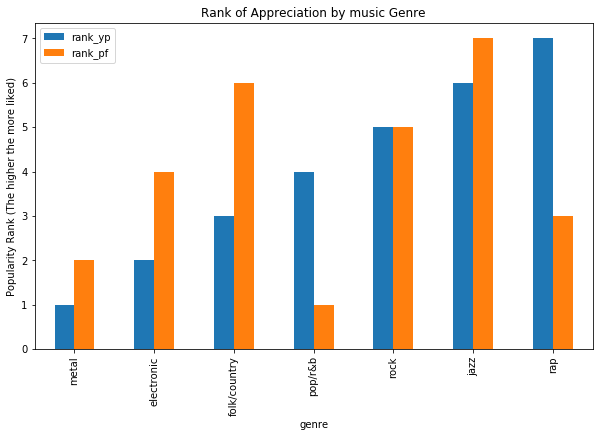

In [17]:
agg[["rank_yp","rank_pf"]].plot.bar(figsize = (10,6))
plt.title("Rank of Appreciation by music Genre")
plt.ylabel("Popularity Rank (The higher the more liked)")
plt.show()

# Hypothesis #1 Music Type vs. Educational level

In [18]:
#list(yp_df.columns)

In [19]:
yp_edu_df = yp_df[[
#'Music',
 'Dance',
 'Folk',
'Country',
'Classical music',
'Musical',
 'Pop',
 'Rock',
 'Metal or Hardrock',
 'Punk',
 'Hiphop, Rap',
 'Reggae, Ska',
 'Swing, Jazz',
 'Rock n roll',
 'Alternative',
 'Latino',
 'Techno, Trance',
 'Opera',
 #'Folk, Country',
 'Education']]

In [20]:
yp_edu_df.Education.value_counts()

secondary school                    621
college/bachelor degree             212
masters degree                       81
primary school                       80
currently a primary school pupil     10
doctorate degree                      5
Name: Education, dtype: int64

In [21]:
yp_edu_df["Education"] = yp_edu_df.Education.apply(lambda x: "3 MA" if x== 'masters degree' else "2 BA" if x == 'college/bachelor degree' else "1 Highschool" if x == 'secondary school' else x  );


/Users/pietrassyk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
yp_edu_df

,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Education
0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,2 BA
1,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,4.0,1.0,3.0,1.0,4.0,4.0,2.0,1.0,1.0,2 BA
2,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,4.0,1.0,4.0,3.0,5.0,5.0,5.0,1.0,3.0,1 Highschool
3,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,2.0,2.0,1.0,2.0,5.0,1.0,2.0,1.0,2 BA
4,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,2.0,5.0,3.0,2.0,1.0,2.0,4.0,2.0,2.0,1 Highschool
5,2.0,3.0,2.0,3.0,3.0,2.0,5.0,5.0,3.0,4.0,3.0,4.0,4.0,5.0,3.0,1.0,3.0,1 Highschool
6,5.0,3.0,1.0,2.0,2.0,5.0,3.0,1.0,1.0,3.0,1.0,1.0,2.0,3.0,3.0,5.0,2.0,1 Highschool
7,3.0,2.0,1.0,2.0,2.0,4.0,5.0,1.0,2.0,3.0,2.0,2.0,3.0,1.0,2.0,3.0,2.0,2 BA
8,3.0,1.0,1.0,2.0,4.0,3.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,1 Highschool
9,2.0,5.0,2.0,2.0,5.0,3.0,5.0,2.0,3.0,2.0,4.0,4.0,4.0,4.0,5.0,1.0,2.0,1 Highschool


In [23]:
HS_df = yp_edu_df.loc[yp_edu_df.Education == '1 Highschool' ]
BA_df = yp_edu_df.loc[yp_edu_df.Education == '2 BA' ]
MA_df = yp_edu_df.loc[yp_edu_df.Education == '3 MA' ]

In [25]:
BA_agg = BA_df.agg(["median","mean"]).transpose().sort_values("mean", ascending = False)
MA_agg = MA_df.agg(["median","mean"]).transpose().sort_values("mean", ascending = False)
HS_agg = HS_df.agg(["median","mean"]).transpose().sort_values("mean", ascending = False)

In [31]:
yp_edu_df = pd.concat([HS_df,BA_df,MA_df])
#yp_edu_df.groupby("Education").agg(["median"])

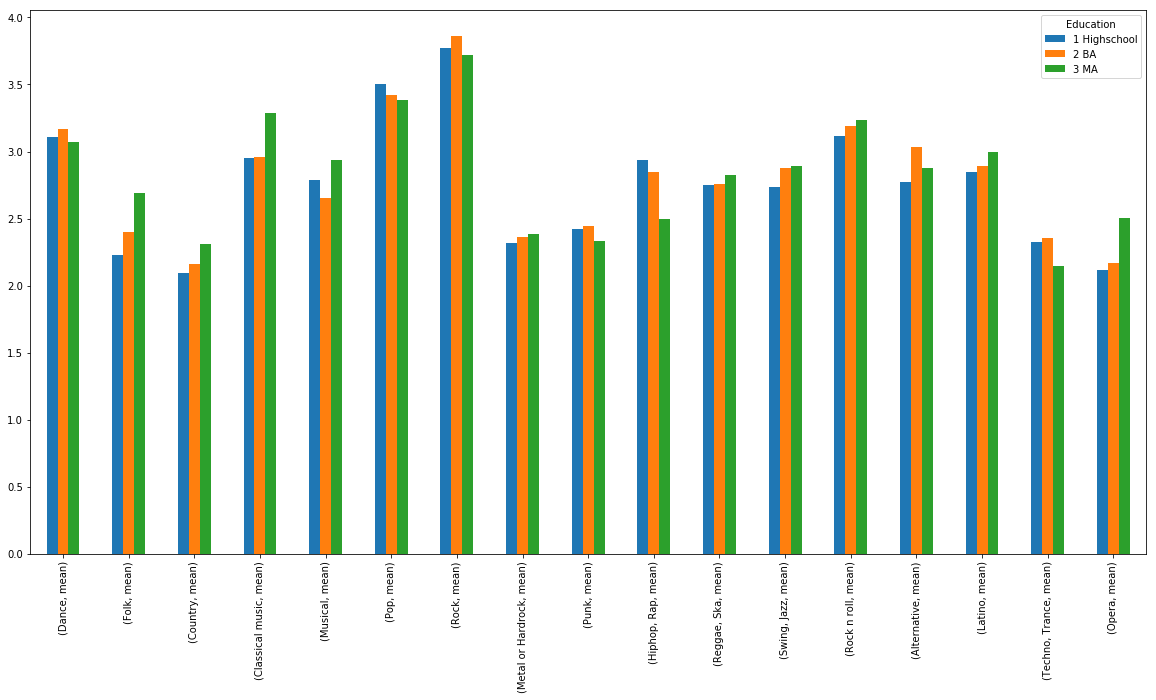

In [32]:
yp_edu_df.groupby("Education").agg(["mean"]).transpose().plot.bar(figsize=(20,10))

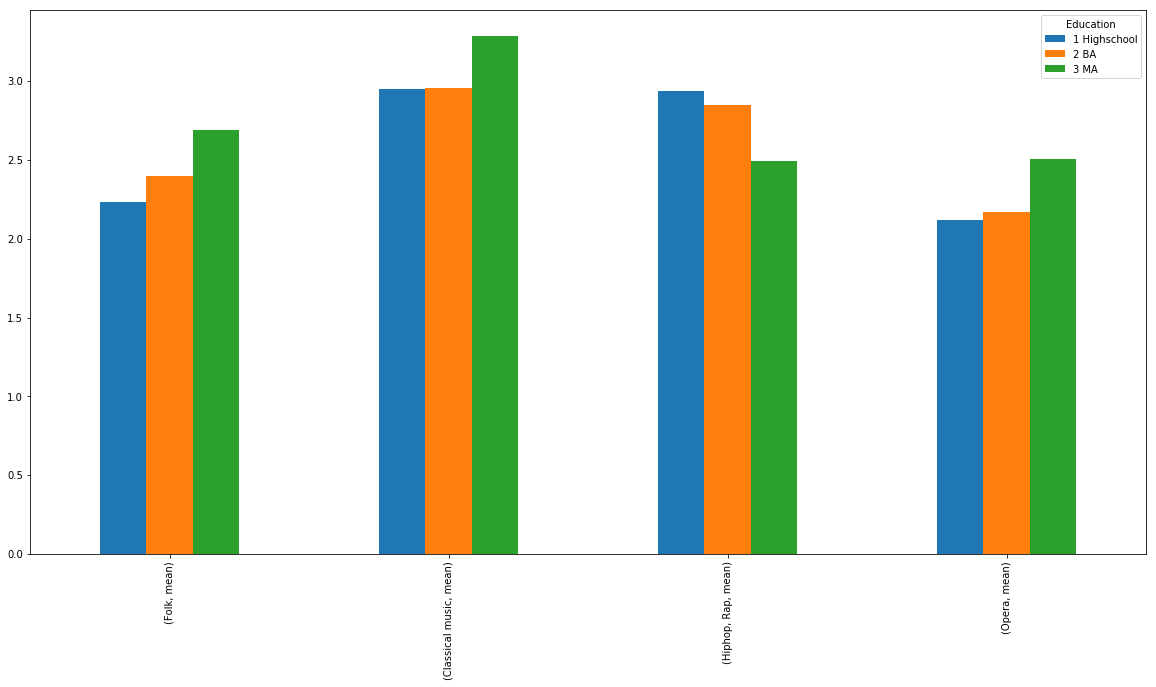

In [145]:
yp_edu_df[
    ["Education",
     "Folk",
     "Classical music",
    "Hiphop, Rap",
    "Opera"]
].groupby("Education").agg(["mean"]).transpose().plot.bar(figsize=(20,10))

## Hypothesis testing for Hypothesis #1

In [37]:
import scipy.stats as stats

In [ ]:
#Folk music preference

In [45]:
stats.ttest_ind(BA_df.Folk,MA_df.Folk, equal_var = False)

Ttest_indResult(statistic=-1.871859528512056, pvalue=0.0633147299136274)

In [46]:
stats.ttest_ind(HS_df.Folk,MA_df.Folk, equal_var = False)

Ttest_indResult(statistic=-3.2634133462844885, pvalue=0.001510783458754163)

In [47]:
stats.ttest_ind(HS_df.Folk,BA_df.Folk, equal_var = False)

Ttest_indResult(statistic=-1.8542483523898132, pvalue=0.06452823611810851)

In [53]:
ttt = [1,2,3]
list(it.combinations(ttt,2))

[(1, 2), (1, 3), (2, 3)]

In [135]:
import itertools as it
def ttest_against(sample_dfs, feature, equal_var = False , two_tailed = True, alpha=0.05):
    testresults = []
    if two_tailed:
        alpha = alpha/2
    combinations = list(it.combinations(sample_dfs,2))
    for combination in combinations:
        p = stats.ttest_ind(combination[0][feature],combination[1][feature], equal_var = equal_var)[1]
        H0_reject = p<alpha
        print(f"Tested ID: {id(combination[0])} vs. {id(combination[1])} on {feature} - result: {p}, reject H0: {H0_reject}")
        testresults.append((id(combination[0]),id(combination[1]),feature,p,H0_reject))
    return testresults
    
    

In [136]:
sample_dfs = [HS_df,BA_df,MA_df]
IDs = [str(id(x))[-3:] for x in sample_dfs]
IDs

['280', '016', '336']

In [139]:
BA_df.columns[:-1]

Index(['Dance', 'Folk', 'Country', 'Classical music', 'Musical', 'Pop', 'Rock',
       'Metal or Hardrock', 'Punk', 'Hiphop, Rap', 'Reggae, Ska',
       'Swing, Jazz', 'Rock n roll', 'Alternative', 'Latino', 'Techno, Trance',
       'Opera'],
      dtype='object')

In [140]:
pos_res = []
for feature in BA_df.columns[:-1]:
    for test in ttest_against(sample_dfs,feature):
        if test[4]:
            pos_res.append(test)
            

Tested ID: 112316285280 vs. 112316287016 on Dance - result: 0.5618015305323453, reject H0: False
Tested ID: 112316285280 vs. 112316285336 on Dance - result: 0.7950846595358091, reject H0: False
Tested ID: 112316287016 vs. 112316285336 on Dance - result: 0.5633829503325224, reject H0: False
Tested ID: 112316285280 vs. 112316287016 on Folk - result: 0.06452823611810851, reject H0: False
Tested ID: 112316285280 vs. 112316285336 on Folk - result: 0.001510783458754163, reject H0: True
Tested ID: 112316287016 vs. 112316285336 on Folk - result: 0.0633147299136274, reject H0: False
Tested ID: 112316285280 vs. 112316287016 on Country - result: 0.4714505743418962, reject H0: False
Tested ID: 112316285280 vs. 112316285336 on Country - result: 0.09579876485765096, reject H0: False
Tested ID: 112316287016 vs. 112316285336 on Country - result: 0.2972074069286843, reject H0: False
Tested ID: 112316285280 vs. 112316287016 on Classical music - result: 0.9429030627711955, reject H0: False
Tested ID: 112

In [141]:
pos_res

[(112316285280, 112316285336, 'Folk', 0.001510783458754163, True),
 (112316285280, 112316285336, 'Classical music', 0.01492397143708319, True),
 (112316285280, 112316285336, 'Hiphop, Rap', 0.006729709279404626, True),
 (112316285280, 112316287016, 'Alternative', 0.01748244175628586, True),
 (112316285280, 112316285336, 'Opera', 0.008057756135654228, True)]